# Exploratory Data Analysis Notebook

This notebook is designed to explore the dataset that was provided, assess its quality (images and labels), and identify any potential preprocessing steps that could be useful (even necessary) before training any model.

In [7]:
# Importing the required libraries

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

sys.path.append(os.path.abspath(os.path.join('../data')))
sys.path.append(os.path.abspath(os.path.join('../src')))

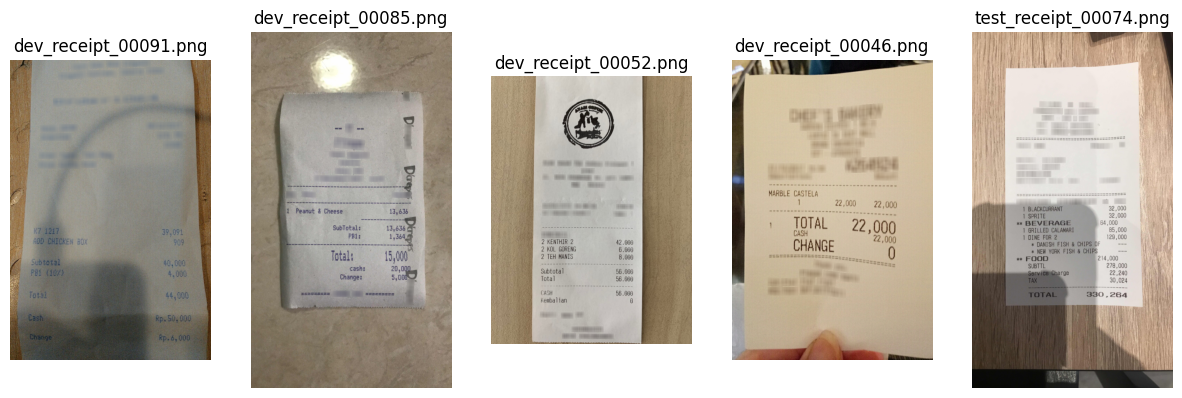

In [6]:
# Visualising some sample images from the dataset
data_dir = '../data/images/'

# Display the 5 first sample images from the dataset
n_images = 5
image_files = os.listdir(data_dir)[:n_images]

plt.figure(figsize=(15, 5))
for i, image_file in enumerate(image_files):
    img = Image.open(os.path.join(data_dir, image_file))
    plt.subplot(1, n_images, i + 1)
    plt.imshow(img)
    plt.title(image_file)
    plt.axis('off')
plt.show()

The sample images above clearly show that the dataset contains a variety of receipt formats, fonts, constrasts, background colors, and lighting conditions. 

We can comment on the images:
- Image dev_receipt_00091.png: This receipt shows poor contrast between the text and the receipt background. It also has some shadows and lighting variations that could make text recognition more challenging. Finally, the receipt is on a brownish surface, which could introduce additional noise, but also help in segmenting the receipt from the background, if that is a lead we want to explore by the way.
- Image dev_receipt_00085.png: This receipt has a cleaner appearance with better contrast between the text and the receipt background. It does not have significant shadows or lighting issues, making it easier for OCR models to recognize the text. Yet, the receipt seems to be slightly crumpled, but not on the entire surface.
- Image dev_receipt_00052.png: Though the receipt has good contrast, is well-lit, and not crumpled, it has a logo at the top that could potentially interfere with text recognition if the model is not trained to handle such cases.
- and so on for the other images...

We can note that all receipts contain blurred areas, which are likely to infer with model training and performance. We will probably need to address this issue in our preprocessing steps. TBC

Having also explored the dataset, we can display other images that show different challenges, such as:
- Receipts with handwritten notes/markings: dev_receipt_00016.png, etc.
- Receipts with significant crumpling or folds: dev_receipt_00026.png, etc.
- Receipts that are poorly lit: dev_receipt_00043.png, etc.

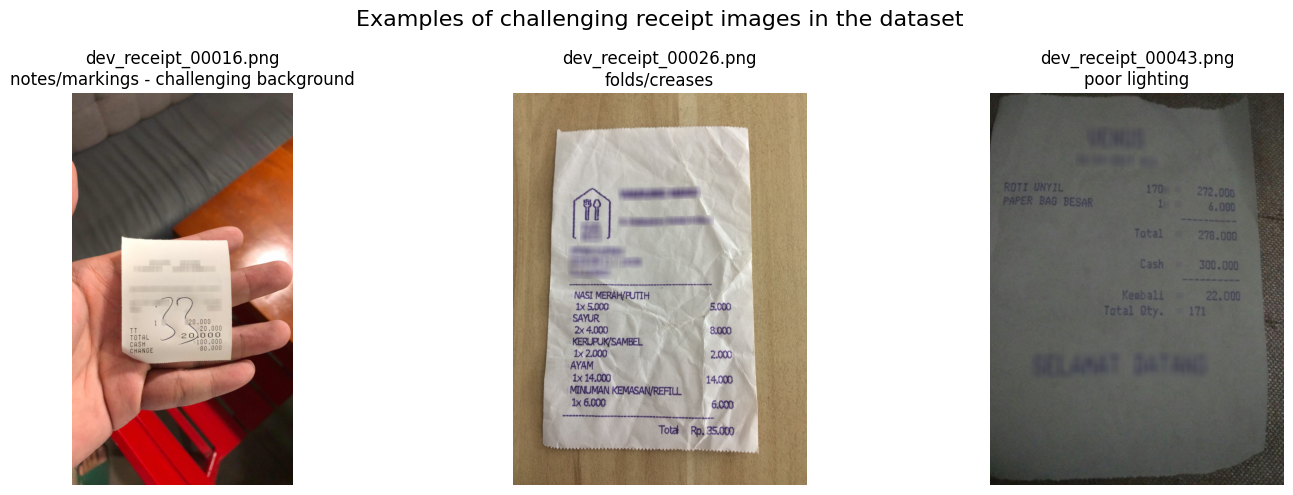

In [13]:
# Display receipts dev_receipt_00016.png, dev_receipt_00026.png, dev_receipt_00043.png
sample_images = ['dev_receipt_00016.png', 'dev_receipt_00026.png', 'dev_receipt_00043.png']
issues = ['notes/markings - challenging background', 'folds/creases', 'poor lighting']
titles = [f"{img}\n{issue}" for img, issue in zip(sample_images, issues)]
plt.figure(figsize=(15, 5))
for i, image_file in enumerate(sample_images):
    img = Image.open(os.path.join(data_dir, image_file))
    plt.subplot(1, len(sample_images), i + 1)
    plt.imshow(img)
    plt.title(titles[i])
    plt.axis('off')
plt.suptitle('Examples of challenging receipt images in the dataset', fontsize=16)
plt.tight_layout()
plt.savefig('../reports/figures/challenging_receipt_images.png')
plt.show()